### Notebook Obejectives:
* Load and check enriched and encoded scraper data
* Train the Xgboost model with the data if needed check hyperparameters
* Evaluate the weight of the features and if needed do dimentionality reduction
* Use a base set of samples - not random
* Transform the target variable with natural log for better distribution

In [11]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import Markdown, display

In [2]:
# Option to show all the DataFrame columns
pd.options.display.max_columns = None

# Ignore competability warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('../resources/data_encoded_pickle', 'rb') as f:
    encoded_data = pickle.load(f)

In [4]:
with open('../resources/enrich_data_pickle', 'rb') as f:
    enriched_data = pickle.load(f)

In [5]:
encoded_data.shape

(21562, 163)

In [6]:
enriched_data.shape

(21562, 25)

In [8]:
encoded_data.loc[
    [1560, 2345, 3560, 4540, 5777, 6432, 7356, 8945, 9056, 10456,
     11235, 12789, 13567, 14784, 15678, 16985, 18565, 19111, 20001, 20999]
]

,sqr_m,year,floor,gas,heating,furnished,entrance_control,security,passageway,adj_price,park_district,adj_population,green_area,has_metro,nr_supermarkets,has_hospital,apartment_type_1-STAEN,apartment_type_2-STAEN,apartment_type_3-STAEN,apartment_type_4-STAEN,apartment_type_ATELIE,apartment_type_MEZONET,apartment_type_MNOGOSTAEN,district_7th 11th kilometer,district_Abdovica,district_Banishora,district_Belite brezi,district_Benkovski,district_Borovo,district_Botunets,district_Botunets 2,district_Boyana,district_Bukston,district_Centyr,district_Chelopechene,district_Dianabad,district_Dimityr Milenkov,district_Doktorski pametnik,district_Dragalevtsi,district_Drujba 1,district_Drujba 2,district_Durvenitsa,district_Eksperimentalen,district_Filipovci,district_Fondovi jilishta,district_Geo Milev,district_Gevgeliski,district_Gorna Banya,district_Gorublyane,district_Gotse Delchev,district_Gradina,district_Hadji Dimityr,district_Hipodruma,district_Hladilnika,district_Iliantsi,district_Ilinden,district_Ivan Vazov,district_Izgrev,district_Iztok,district_Karpuzitsa,district_Knyajevo,district_Krasna polyana 1,district_Krasna polyana 2,district_Krasna polyana 3,district_Krasno selo,district_Krystova vada,district_Lagera,district_Levski,district_Levski G,district_Levski V,district_Lozenets,district_Lulin - centyr,district_Lulin 1,district_Lulin 10,district_Lulin 2,district_Lulin 3,district_Lulin 4,district_Lulin 5,district_Lulin 6,district_Lulin 7,district_Lulin 8,district_Lulin 9,district_Malashevtsi,district_Malinova dolina,district_Manastirski livadi,district_Medicinska akademia,district_Mladost 1,district_Mladost 1A,district_Mladost 2,district_Mladost 3,district_Mladost 4,district_Moderno predgradie,district_Musagenitsa,district_NPZ Hadji Dimityr,district_Nadejda 1,district_Nadejda 2,district_Nadejda 3,district_Nadejda 4,district_Obelya,district_Obelya 1,district_Obelya 2,district_Oborishte,district_Orlandovci,district_Ovcha kupel,district_Ovcha kupel 1,district_Ovcha kupel 2,district_PZ Hladilnika,district_Pavlovo,district_Poduyane,district_Poligona,district_Razsadnika,district_Reduta,district_Republika,district_Serdika,district_Simeonovo,district_Slatina,district_Slavia,district_Strelbishte,district_Studentski grad,district_Suhata reka,district_Sveta Troica,district_Svoboda,district_Tolstoy,district_Triygylnika,district_Vitosha,district_Voenna rampa,district_Vrajdebna,district_Vrybnitsa 1,district_Vrybnitsa 2,district_Yavorov,district_Zaharna fabrika,district_Zapaden park,district_Zona B-18,district_Zona B-19,district_Zona B-5,district_Zona B-5-3,construction_type_Brick,construction_type_EPK,construction_type_PK,construction_type_Panel,construction_type_Timbered,region_Ilinden,region_Iskar,region_Izgrev,region_Krasna polyana,region_Krasno selo,region_Kremikovtsi,region_Lozenets,region_Lyulin,region_Mladost,region_Nadezhda,region_Oborishte,region_Ovcha kupel,region_Poduyane,region_Serdika,region_Slatina,region_Sredets,region_Sredets_Oborishte,region_Studentski,region_Triadica,region_Vazrazhdane,region_Vitosha,region_Vrabnitsa
1560,75,2019.0,1.0,0,1,0,1,1,0,56620.0,True,58388.0,149.75,False,0,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2345,80,1960.0,1.0,0,1,1,1,0,0,170810.0,True,69831.3,903.23,False,0,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3560,72,2021.0,4.0,1,0,0,0,0,0,86450.0,True,69796.1,217.86,False,0,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

In [9]:
enriched_data.loc[
    [1560, 2345, 3560, 4540, 5777, 6432, 7356, 8945, 9056, 10456,
     11235, 12789, 13567, 14784, 15678, 16985, 18565, 19111, 20001, 20999]
]

,apartment_type,district,price,sqr_m,price_sqrm,currency,year,floor,gas,heating,construction_type,furnished,entrance_control,security,passageway,adj_price,adj_price_sqrm,park_district,region,population,adj_population,green_area,has_metro,nr_supermarkets,has_hospital
1560,2-STAEN,Vitosha,59600.0,75,794.66,EUR,2019.0,1.0,0,1,Brick,0,1,1,0,56620.0,754.9270,True,Lozenets,53080,58388.0,149.75,False,0,False
2345,2-STAEN,Doktorski pametnik,179800.0,80,2247.50,EUR,1960.0,1.0,0,1,Brick,1,1,0,0,170810.0,2135.1250,True,Sredets_Oborishte,63483,69831.3,903.23,False,0,False
3560,2-STAEN,Krystova vada,91000.0,72,1263.88,EUR,2021.0,4.0,1,0,Brick,0,0,0,0,86450.0,1200.6860,True,Triadica,63451,69796.1,217.86,False,0,True
4540,2-STAEN,Malinova dolina,49494.0,52,951.80,EUR,2015.0,1.0,0,0,Brick,0,0,0,0,47019.3,904.2100,False,Mladost,102899,113188.9,411.40,False,1,False
5777,2-STAEN,Nadejda 1,73630.0,98,751.32,EUR,2000.0,7.0,0,1,Brick,0,0,0,0,69948.5,713.7540,False,Nadezhda,67905,74695.5,17.45,True,0,True
6432,2-STAEN,Ovcha kupel,85000.0,89,955.05,EUR,2020.0,6.0,1,0,Brick,0,1,0,0,80750.0,907.2975,False,Ovcha kupel,54320,59752.0,115.33,False,0,False
7356,2-STAEN,Studentski grad,72000.0,80,900.00,EUR,NaN,3.0,0,0,Brick,0,0,0,0,68400.0,855.0000,True,Studentski,71961,79157.1,227.94,False,1,False
8945,3-STAEN,Boyana,165000.0,116,1422.41,EUR,2018.0,2.0,0,0,Brick,0,0,0,0,156750.0,1351.2895,True,Vitosha,61467,67613.7,73.43,False,0,False
9056,3-STAEN,Bukston,116000.0,90,1288.88,EUR,1987.0,4.0,0,0,Panel,0,0,0,0,110200.0,1224.4360,True,Vitosha,61467,67613.7,73.43,False,1,False
10456,3-STAEN,Dragalevtsi,177500.0,133,1334.58,EUR,2021.0,2.0,1,0,Brick,0,0,0,0,168625.0,1267.8510,True,Vitosha,61467,67613.7,73.43,False,0,False


In [10]:
enriched_data.loc[[8878]]

,apartment_type,district,price,sqr_m,price_sqrm,currency,year,floor,gas,heating,construction_type,furnished,entrance_control,security,passageway,adj_price,adj_price_sqrm,park_district,region,population,adj_population,green_area,has_metro,nr_supermarkets,has_hospital
8878,3-STAEN,Boyana,111000.0,170,652.94,EUR,2008.0,0.0,1,0,Brick,0,1,0,0,105450.0,620.293,True,Vitosha,61467,67613.7,73.43,False,0,False


In [11]:
data_test = encoded_data.loc[
    [1560, 2345, 3560, 4540, 5777, 6432, 7356, 8945, 9056, 10456,
     11235, 12789, 13567, 14784, 15678, 16985, 18565, 19111, 20001, 20999]
].copy()

In [12]:
data_test.shape

(20, 163)

In [13]:
df_data = encoded_data.copy()

# Sample data for test
# data_test = df_data.sample(n = 10)
compare_price = data_test.copy()

data_test = data_test.drop(columns=['adj_price'])
data_test = data_test.reset_index(drop=True)

df_data = df_data[~df_data.index.isin(compare_price.index)]

# Split the data and train the model
X = df_data.drop(columns=['adj_price']).copy()
y = df_data.adj_price

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15)
xgboost_parameters = {
        'early_stopping_rounds': 100,
        'num_boost_round': 2000,
        'verbose_eval': False,
        'params': {
            'max_depth': 6,
            'eval_metric': 'rmse',
            'objective': 'reg:linear',
            'eta': 0.05,
            'nthread': 4,
            'silent': True,
        }
    }

train_d = xgb.DMatrix(X_train.values, label=y_train, feature_names=X_train.columns)

watch_list = [(train_d, 'train')]
eval_d = xgb.DMatrix(X_test.values, label=y_test, feature_names=X_test.columns)
watch_list += [(eval_d, 'eval')]

evals_result_data = {}
model = xgb.train(dtrain=train_d, evals=watch_list, evals_result=evals_result_data, **xgboost_parameters)

X_test = xgb.DMatrix(X_test.values, label=y_test, feature_names=X_test.columns)
y_pred = model.predict(X_test)

# Evaluate the results

mse = mean_squared_error(y_test, y_pred)
display(Markdown('---'))
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

to_predict = xgb.DMatrix(data_test.values, feature_names=data_test.columns)
compare_price.loc[:, 'model_price_prediction'] = list(model.predict(to_predict))
result_df = compare_price[['model_price_prediction', 'adj_price']]

pred_price_model = sum(list(result_df.loc[:, 'model_price_prediction']))
actual_price = sum(list(result_df.loc[:, 'adj_price']))

difference_model_actual = pred_price_model - actual_price

display(Markdown('---'))
print('Predicted Price: '+ str(round(pred_price_model, 0)))
print('Actual Price: '+ str(actual_price))
print('Difference:')
print('Model Prediction - Actual Price: ' + str(round(difference_model_actual, 0)))

---

MSE: 1319474397.70
RMSE: 36324.57


---

Predicted Price: 2874955.0
Actual Price: 2917824.3
Difference:
Model Prediction - Actual Price: -42869.0


In [64]:
result_df

,model_price_prediction,adj_price
1560,78442.593750,56620.0
2345,192067.109375,170810.0
3560,83860.515625,86450.0
4540,52586.406250,47019.3
5777,82699.609375,69948.5
6432,77729.664062,80750.0
7356,83430.906250,68400.0
8945,144039.343750,156750.0
9056,100270.296875,110200.0
10456,152408.921875,168625.0


In [65]:
enriched_data.loc[
    [1560, 2345, 3560, 4540, 5777, 6432, 7356, 8945, 9056, 10456,
     11235, 12789, 13567, 14784, 15678, 16985, 18565, 19111, 20001, 20999]
]

,apartment_type,district,price,sqr_m,price_sqrm,currency,year,floor,gas,heating,construction_type,furnished,entrance_control,security,passageway,adj_price,adj_price_sqrm,park_district,region,population,adj_population,green_area,has_metro,nr_supermarkets,has_hospital
1560,2-STAEN,Vitosha,59600.0,75,794.66,EUR,2019.0,1.0,0,1,Brick,0,1,1,0,56620.0,754.9270,True,Lozenets,53080,58388.0,149.75,False,0,False
2345,2-STAEN,Doktorski pametnik,179800.0,80,2247.50,EUR,1960.0,1.0,0,1,Brick,1,1,0,0,170810.0,2135.1250,True,Sredets_Oborishte,63483,69831.3,903.23,False,0,False
3560,2-STAEN,Krystova vada,91000.0,72,1263.88,EUR,2021.0,4.0,1,0,Brick,0,0,0,0,86450.0,1200.6860,True,Triadica,63451,69796.1,217.86,False,0,True
4540,2-STAEN,Malinova dolina,49494.0,52,951.80,EUR,2015.0,1.0,0,0,Brick,0,0,0,0,47019.3,904.2100,False,Mladost,102899,113188.9,411.40,False,1,False
5777,2-STAEN,Nadejda 1,73630.0,98,751.32,EUR,2000.0,7.0,0,1,Brick,0,0,0,0,69948.5,713.7540,False,Nadezhda,67905,74695.5,17.45,True,0,True
6432,2-STAEN,Ovcha kupel,85000.0,89,955.05,EUR,2020.0,6.0,1,0,Brick,0,1,0,0,80750.0,907.2975,False,Ovcha kupel,54320,59752.0,115.33,False,0,False
7356,2-STAEN,Studentski grad,72000.0,80,900.00,EUR,NaN,3.0,0,0,Brick,0,0,0,0,68400.0,855.0000,True,Studentski,71961,79157.1,227.94,False,1,False
8945,3-STAEN,Boyana,165000.0,116,1422.41,EUR,2018.0,2.0,0,0,Brick,0,0,0,0,156750.0,1351.2895,True,Vitosha,61467,67613.7,73.43,False,0,False
9056,3-STAEN,Bukston,116000.0,90,1288.88,EUR,1987.0,4.0,0,0,Panel,0,0,0,0,110200.0,1224.4360,True,Vitosha,61467,67613.7,73.43,False,1,False
10456,3-STAEN,Dragalevtsi,177500.0,133,1334.58,EUR,2021.0,2.0,1,0,Brick,0,0,0,0,168625.0,1267.8510,True,Vitosha,61467,67613.7,73.43,False,0,False


In [66]:
import eli5
eli5.explain_weights(model, top=130, feature_names=list(X.columns))

Weight,Feature
0.0896,sqr_m
0.0821,nr_supermarkets
0.0602,district_Lozenets
0.0584,green_area
0.0560,has_metro
0.0449,park_district
0.0445,district_Ivan Vazov
0.0365,district_Doktorski pametnik
0.0332,adj_population
0.0236,region_Vitosha


#### Check the results without enriching data

In [7]:
with open('../resources/data_no_added_columns', 'rb') as f:
    data_no_added_columns = pickle.load(f)

In [8]:
data_no_added_columns.shape

(21562, 157)

In [69]:
data_test = data_no_added_columns.loc[
    [1560, 2345, 3560, 4540, 5777, 6432, 7356, 8945, 9056, 10456,
     11235, 12789, 13567, 14784, 15678, 16985, 18565, 19111, 20001, 20999]
].copy()

In [70]:
data_test.shape

(20, 157)

In [71]:
df_data = data_no_added_columns.copy()

# Sample data for test
# data_test = df_data.sample(n = 10)
compare_price = data_test.copy()

data_test = data_test.drop(columns=['adj_price'])
data_test = data_test.reset_index(drop=True)

df_data = df_data[~df_data.index.isin(compare_price.index)]

# Split the data and train the model
X = df_data.drop(columns=['adj_price']).copy()
y = df_data.adj_price

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15)
xgboost_parameters = {
        'early_stopping_rounds': 100,
        'num_boost_round': 2000,
        'verbose_eval': False,
        'params': {
            'max_depth': 6,
            'eval_metric': 'rmse',
            'objective': 'reg:linear',
            'eta': 0.05,
            'nthread': 4,
            'silent': True,
        }
    }

train_d = xgb.DMatrix(X_train.values, label=y_train, feature_names=X_train.columns)

watch_list = [(train_d, 'train')]
eval_d = xgb.DMatrix(X_test.values, label=y_test, feature_names=X_test.columns)
watch_list += [(eval_d, 'eval')]

evals_result_data = {}
model = xgb.train(dtrain=train_d, evals=watch_list, evals_result=evals_result_data, **xgboost_parameters)

X_test = xgb.DMatrix(X_test.values, label=y_test, feature_names=X_test.columns)
y_pred = model.predict(X_test)

# Evaluate the results

mse = mean_squared_error(y_test, y_pred)
display(Markdown('---'))
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

to_predict = xgb.DMatrix(data_test.values, feature_names=data_test.columns)
compare_price.loc[:, 'model_price_prediction'] = list(model.predict(to_predict))
result_df = compare_price[['model_price_prediction', 'adj_price']]

pred_price_model = sum(list(result_df.loc[:, 'model_price_prediction']))
actual_price = sum(list(result_df.loc[:, 'adj_price']))

difference_model_actual = pred_price_model - actual_price

display(Markdown('---'))
print('Predicted Price: '+ str(round(pred_price_model, 0)))
print('Actual Price: '+ str(actual_price))
print('Difference:')
print('Model Prediction - Actual Price: ' + str(round(difference_model_actual, 0)))

---

MSE: 1675843224.67
RMSE: 40937.06


---

Predicted Price: 2908252.0
Actual Price: 2917824.3
Difference:
Model Prediction - Actual Price: -9573.0


In [72]:
result_df

,model_price_prediction,adj_price
1560,79415.921875,56620.0
2345,193416.515625,170810.0
3560,83313.242188,86450.0
4540,56622.101562,47019.3
5777,77746.023438,69948.5
6432,78187.242188,80750.0
7356,78402.171875,68400.0
8945,155028.312500,156750.0
9056,99596.804688,110200.0
10456,155070.906250,168625.0


In [73]:
import eli5
eli5.explain_weights(model, top=130, feature_names=list(X.columns))

Weight,Feature
0.1305,region_Sredets_Oborishte
0.0758,region_Izgrev
0.0540,district_Ivan Vazov
0.0529,district_Lozenets
0.0419,district_Malinova dolina
0.0410,region_Ovcha kupel
0.0399,district_Oborishte
0.0391,sqr_m
0.0362,district_Doktorski pametnik
0.0341,district_Lulin 8


#### Scaling of the target variable before enrichment 

In [12]:
with open('../resources/data_no_added_columns', 'rb') as f:
    data_no_added_columns = pickle.load(f)

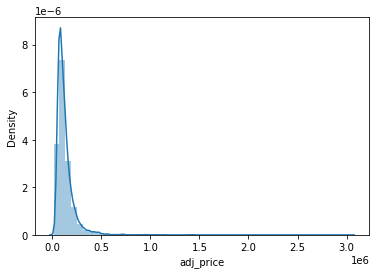

In [13]:
data_no_added_columns.shape

# So we see that we don't have a normal distribution of the data
sns.distplot(data_no_added_columns.adj_price)
plt.show()

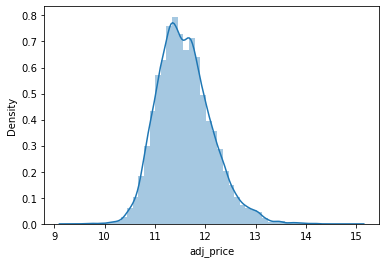

In [14]:

data_no_added_columns.adj_price = np.log(data_no_added_columns.adj_price)

# So we see that we don't have a normal distribution of the data
sns.distplot(data_no_added_columns.adj_price)
plt.show()

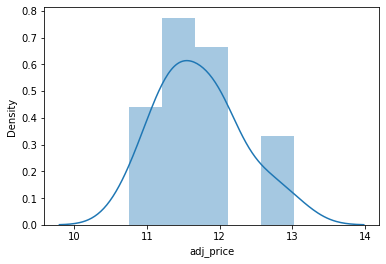

In [15]:
data_test = data_no_added_columns.loc[
    [1560, 2345, 3560, 4540, 5777, 6432, 7356, 8945, 9056, 10456,
     11235, 12789, 13567, 14784, 15678, 16985, 18565, 19111, 20001, 20999]
].copy()

sns.distplot(data_test.adj_price)
plt.show()

In [101]:
df_data = data_no_added_columns.copy()

# Sample data for test
# data_test = df_data.sample(n = 10)
compare_price = data_test.copy()

data_test = data_test.drop(columns=['adj_price'])
data_test = data_test.reset_index(drop=True)

df_data = df_data[~df_data.index.isin(compare_price.index)]

# Split the data and train the model
X = df_data.drop(columns=['adj_price']).copy()
y = df_data.adj_price

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15)
xgboost_parameters = {
        'early_stopping_rounds': 100,
        'num_boost_round': 2000,
        'verbose_eval': False,
        'params': {
            'max_depth': 6,
            'eval_metric': 'rmse',
            'objective': 'reg:linear',
            'eta': 0.05,
            'nthread': 4,
            'silent': True,
        }
    }

train_d = xgb.DMatrix(X_train.values, label=y_train, feature_names=X_train.columns)

watch_list = [(train_d, 'train')]
eval_d = xgb.DMatrix(X_test.values, label=y_test, feature_names=X_test.columns)
watch_list += [(eval_d, 'eval')]

evals_result_data = {}
model = xgb.train(dtrain=train_d, evals=watch_list, evals_result=evals_result_data, **xgboost_parameters)

X_test = xgb.DMatrix(X_test.values, label=y_test, feature_names=X_test.columns)
y_pred = model.predict(X_test)

# Evaluate the results

mse = mean_squared_error(y_test, y_pred)
display(Markdown('---'))
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

to_predict = xgb.DMatrix(data_test.values, feature_names=data_test.columns)
compare_price.loc[:, 'model_price_prediction'] = list(model.predict(to_predict))
result_df = compare_price[['model_price_prediction', 'adj_price']]

pred_price_model = sum(list(result_df.loc[:, 'model_price_prediction']))
actual_price = sum(list(result_df.loc[:, 'adj_price']))

difference_model_actual = pred_price_model - actual_price

display(Markdown('---'))
print('Predicted Price: '+ str(round(pred_price_model, 0)))
print('Actual Price: '+ str(actual_price))
print('Difference:')
print('Model Prediction - Actual Price: ' + str(round(difference_model_actual, 0)))

---

MSE: 0.03
RMSE: 0.17


---

Predicted Price: 235.0
Actual Price: 234.33307147779874
Difference:
Model Prediction - Actual Price: 0.0


In [102]:
result_df

,model_price_prediction,adj_price
1560,11.316817,10.944118
2345,12.054633,12.048307
3560,11.318550,11.367321
4540,10.961063,10.758313
5777,11.316861,11.155515
6432,11.307578,11.299113
7356,11.207797,11.133128
8945,11.890120,11.962407
9056,11.515153,11.610052
10456,11.936522,12.035433


In [103]:
result_df.model_price_prediction = np.exp(result_df.model_price_prediction)
result_df.adj_price = np.exp(result_df.adj_price)
result_df

,model_price_prediction,adj_price
1560,82192.331310,56620.0
2345,171893.974872,170810.0
3560,82334.879808,86450.0
4540,57587.648332,47019.3
5777,82195.937086,69948.5
6432,81436.437491,80750.0
7356,73702.872314,68400.0
8945,145818.729804,156750.0
9056,100222.994889,110200.0
10456,152744.593783,168625.0


#### Scaling of the target variable with new features

In [16]:
with open('../resources/data_encoded_pickle', 'rb') as f:
    encoded_data = pickle.load(f)

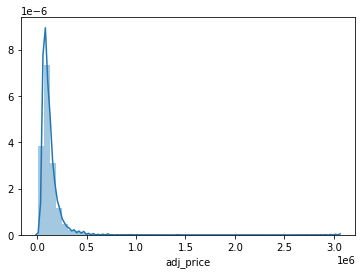

In [131]:
encoded_data.shape

# So we see that we don't have a normal distribution of the data
sns.distplot(encoded_data.adj_price)
plt.show()

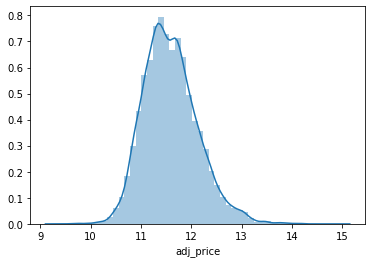

In [132]:
encoded_data.adj_price = np.log(encoded_data.adj_price)

# With adjusted price
sns.distplot(encoded_data.adj_price)
plt.show()

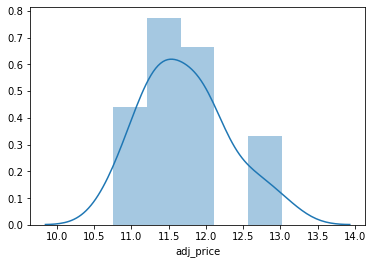

In [133]:
data_test = encoded_data.loc[
    [1560, 2345, 3560, 4540, 5777, 6432, 7356, 8945, 9056, 10456,
     11235, 12789, 13567, 14784, 15678, 16985, 18565, 19111, 20001, 20999]
].copy()

sns.distplot(data_test.adj_price)
plt.show()

In [134]:
df_data = encoded_data.copy()

# Sample data for test
# data_test = df_data.sample(n = 10)
compare_price = data_test.copy()

data_test = data_test.drop(columns=['adj_price'])
data_test = data_test.reset_index(drop=True)

df_data = df_data[~df_data.index.isin(compare_price.index)]

# Split the data and train the model
X = df_data.drop(columns=['adj_price']).copy()
y = df_data.adj_price

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15)
xgboost_parameters = {
        'early_stopping_rounds': 100,
        'num_boost_round': 2000,
        'verbose_eval': False,
        'params': {
            'max_depth': 6,
            'eval_metric': 'rmse',
            'objective': 'reg:linear',
            'eta': 0.05,
            'nthread': 4,
            'silent': True,
        }
    }

train_d = xgb.DMatrix(X_train.values, label=y_train, feature_names=X_train.columns)

watch_list = [(train_d, 'train')]
eval_d = xgb.DMatrix(X_test.values, label=y_test, feature_names=X_test.columns)
watch_list += [(eval_d, 'eval')]

evals_result_data = {}
model = xgb.train(dtrain=train_d, evals=watch_list, evals_result=evals_result_data, **xgboost_parameters)

X_test = xgb.DMatrix(X_test.values, label=y_test, feature_names=X_test.columns)
y_pred = model.predict(X_test)

# Evaluate the results

mse = mean_squared_error(y_test, y_pred)
display(Markdown('---'))
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

to_predict = xgb.DMatrix(data_test.values, feature_names=data_test.columns)
compare_price.loc[:, 'model_price_prediction'] = list(model.predict(to_predict))
result_df = compare_price[['model_price_prediction', 'adj_price']]

pred_price_model = sum(list(result_df.loc[:, 'model_price_prediction']))
actual_price = sum(list(result_df.loc[:, 'adj_price']))

difference_model_actual = pred_price_model - actual_price

display(Markdown('---'))
print('Predicted Price: '+ str(round(pred_price_model, 0)))
print('Actual Price: '+ str(actual_price))
print('Difference:')
print('Model Prediction - Actual Price: ' + str(round(difference_model_actual, 0)))

---

MSE: 0.03
RMSE: 0.17


---

Predicted Price: 235.0
Actual Price: 234.33307147779874
Difference:
Model Prediction - Actual Price: 0.0


In [135]:
result_df

,model_price_prediction,adj_price
1560,11.278721,10.944118
2345,12.175879,12.048307
3560,11.332881,11.367321
4540,10.948915,10.758313
5777,11.309429,11.155515
6432,11.329148,11.299113
7356,11.223203,11.133128
8945,11.908737,11.962407
9056,11.462553,11.610052
10456,12.000297,12.035433


In [136]:
result_df.model_price_prediction = np.exp(result_df.model_price_prediction)
result_df.adj_price = np.exp(result_df.adj_price)
result_df

,model_price_prediction,adj_price
1560,79119.991251,56620.0
2345,194051.433643,170810.0
3560,83523.305010,86450.0
4540,56892.256880,47019.3
5777,81587.322609,69948.5
6432,83212.120272,80750.0
7356,74847.104524,68400.0
8945,148558.958092,156750.0
9056,95087.521393,110200.0
10456,162803.070463,168625.0


In [137]:
import eli5
eli5.explain_weights(model, top=130, feature_names=list(X.columns))

Weight,Feature
0.0867,park_district
0.0523,sqr_m
0.0432,district_Lozenets
0.0380,district_Ivan Vazov
0.0379,district_Doktorski pametnik
0.0320,green_area
0.0278,has_hospital
0.0271,region_Triadica
0.0230,has_metro
0.0221,region_Vitosha
